# Approximating a Reflection Map

In this tutorial we show how to painlessly train a neural ODE for approximating the **reflection map** 

$$
    y = -x
$$

This tutorial also serves as a warning on limitations of *vanilla* ODE models which should always be considered when designing your task-specific architecture.\
In fact, vanilla Neural ODEs cannot approximate (in 1D) functions which requires the flows to cross, e.g. the reflection map $y=-x$ as they would break the uniqueness of solutions (and thus the determinism). As we show later, one way to overcome this issue is to employ **data-controlled** models.

In [1]:
from torchdyn.core import NeuralODE
from torchdyn.nn import DataControl, DepthCat, Augmenter
from torchdyn.utils import *

**Data**

The dataset contains pairs of `(-1, 1)` and `(1, -1)`

In [2]:
import torch
import torch.utils.data as data

n_points = 100
X = torch.linspace(-1,1, n_points).reshape(-1,1)
y = -X

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train, y_train = torch.Tensor(X).to(device), torch.Tensor(y).to(device)

bs = len(X)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=bs, shuffle=False)

**Learner**

In [3]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module, settings:dict={}):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model(x)   
        loss = nn.MSELoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

## Uncontrolled Neural ODE models

We first consider the following neural ODE variants: `depth-invariant` and `depth-variant` ("cat"). As we expect, these models will **NOT** be able to approximate the reflection map.

In [4]:
# vanilla depth-invariant
func = nn.Sequential(
        nn.Linear(1, 64),
        nn.Tanh(),
        nn.Linear(64,1)
        )


# vanilla depth-variant
func_dv = nn.Sequential(DepthCat(1),
        nn.Linear(2, 64),
        nn.Tanh(),
        nn.Linear(64,1)
        )

funcs = [func, func_dv]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | NeuralDE | 193   


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | NeuralDE | 257   


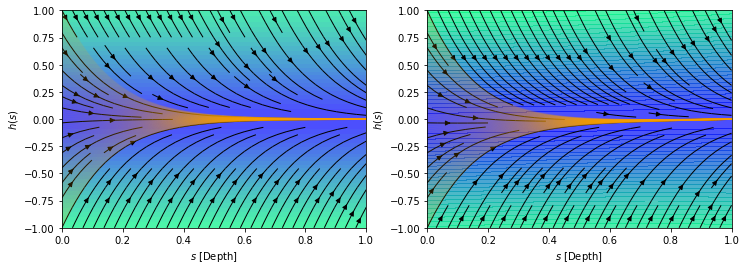

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plot_settings = {'n_grid':30, 'x_span':[-1,1], 'device':device}

for i, f in enumerate(funcs):
    # define the model
    model = NeuralDE(f, solver='dopri5').to(device)
    # train the neural ODE
    learn = Learner(model)
    trainer = pl.Trainer(min_epochs=100, max_epochs=200, gpus=1)
    trainer.fit(learn)
    
    # plot the learned flows
    plt.subplot(1,2,1+i)
    s_span = torch.linspace(0,1,100)
    traj = model.trajectory(X_train, s_span).cpu().detach()
    plot_traj_vf_1D(model, s_span, traj, n_grid=30, x_span=[-1,1], device=device);

## Controlled Neural ODE models

Following the work in [Massaroli S., Poli M., et al., 2020](https://arxiv.org/abs/2002.08071), we can easily approximate the reflection map leveraging **data-controlled Neural ODEs**. Data-control allows the Neural ODE to learn a family of vector fields instead of a single one, via conditioning the vector field `f` with the initial condition `x`.

In [6]:
# define the data-controlled model
f = nn.Sequential(DataControl(),
                  nn.Linear(2, 64),
                  nn.Tanh(),
                  nn.Linear(64,1)
)

model = NeuralODE(f, solver='dopri5').to(device)

In [7]:
# train the neural ODE
learn = Learner(model)
trainer = pl.Trainer(min_epochs=200, max_epochs=250, gpus=1)
trainer.fit(learn)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | NeuralDE | 257   


1

**Plots**

In [8]:
# evaluate the trajectories of each data point
s_span = torch.linspace(0,1,100)
traj = model.trajectory(X_train, s_span).cpu().detach()

Text(0.5, 1.0, 'Depth-Trajectories of Controlled Neural ODEs')

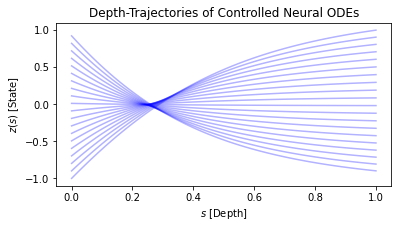

In [9]:
# plot the depth evolution of the data
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
ax.plot(s_span, traj[:,::5,0], color='blue', alpha=.3);
ax.set_xlabel(r"$s$ [Depth]")
ax.set_ylabel(r"$z(s)$ [State]")
ax.set_title(r"Depth-Trajectories of Controlled Neural ODEs")

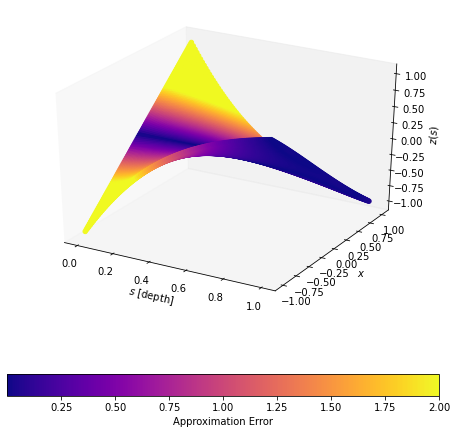

In [10]:
# plot the evolution of the data in the s-x-h space
from mpl_toolkits.mplot3d import Axes3D

n_grid=30
x_span=[-1,1]
fig = plt.figure(figsize=(6,6)) ; ax =Axes3D(fig)
ss = torch.linspace(s_span[0], s_span[-1], n_grid)
xx = torch.linspace(x_span[0], x_span[-1], n_grid)
S, X = torch.meshgrid(ss,xx) ; 
u_traj = traj[0,:,0].repeat(traj.shape[1],1)
e = torch.abs(y.T - traj[:,:,0])
color = plt.cm.plasma(e.numpy())
for i in range(traj.shape[1]):
    tr = ax.scatter(s_span, u_traj[:,i], traj[:,i,0],
                c=color[:,i],alpha=1, cmap=color[:,i], zdir='z')
norm = mpl.colors.Normalize(e.min(),e.max())
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='plasma'),
     label='Approximation Error', orientation='horizontal')
ax.set_xlabel(r"$s$ [depth]"); ax.set_ylabel(r"$x$"); ax.set_zlabel(r"$z(s)$") ; 
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)